In [1]:
# !pip install dtreeviz


# 의사결정트리 분류 기본코드

## #01. 준비작업

### [1] 패키지 가져오기

시각화를 위해서 `dtreeviz` 패키지가 필요하다

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 분석 알고리즘
from sklearn.tree import DecisionTreeClassifier
# 시각화 관련 기능
from sklearn.tree import export_text, plot_tree
import dtreeviz

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## #02. 이진분류 - 피마 인디언 당뇨병 데이터 셋

### [1] 데이터 가져오기

In [3]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링 및 형변환
2. 훈련/검증 데이터 분리

In [4]:
# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# `0`값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

df2['Outcome'] = df2['Outcome'].astype('int')

x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Outcome', test_size=0.2, scalling=False)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

### [3] 의사결정나무 분류 모델 구현

| 하이퍼파라미터       | 설명 | 기본값 | 추천 사항 | `GridSearchCV` 추천값 |
|---------------------|------|--------|-----------|------------------------|
| * `criterion`         | 노드를 분할할 기준. 'gini'는 지니 불순도를, 'entropy'는 정보 이득을 사용함 | 'gini' | 문제에 따라 다르지만, 일반적으로 두 기준 중 하나를 선택해서 실험해보는 걸 권장 | `{'criterion': ['gini', 'entropy']}` |
| `splitter`          | 각 노드에서 분할을 선택하는 방식. 'best'는 최선의 분할을 찾으려고 하고, 'random'은 무작위로 분할을 선택함. | 'best' | 대규모 데이터셋이나 무작위성을 추가하고 싶을 때 'random'을 고려할 수 있음 | `{'splitter': ['best', 'random']}` |
| `max_depth`         | 트리의 최대 깊이를 제한. 깊이가 깊어질수록 모델은 더 복잡해지고 과적합될 가능성이 높아짐 | None   | 과적합을 방지하기 위해 적절한 값으로 설정하는 것이 중요. 데이터와 문제에 따라 최적의 값을 찾아봐함 | `{'max_depth': [None, 10, 20, 30, 40, 50]}` |
| * `min_samples_split` | 노드를 분할하기 위해 필요한 최소 샘플 수. 이 값이 클수록 분할이 적게 일어나 트리가 간단해짐 | 2      | 불필요한 분할을 줄이기 위해 이 값을 조정할 수 있음. 크로스 밸리데이션을 통해 적절한 값을 찾아봐야 함 | `{'min_samples_split': [2, 5, 10]}` |
| * `min_samples_leaf`  | 리프 노드가 되기 위해 필요한 최소 샘플 수. 이 값도 클수록 모델이 단순해지고 과적합을 방지할 수 있음 | 1      | 리프 노드의 크기를 조정하여 과적합을 방지할 수 있음 데이터의 특성에 맞게 조정해보는 걸 권장. | `{'min_samples_leaf': [1, 2, 4]}` |
| `max_features`      | 최적의 분할을 찾기 위해 고려할 최대 특성 수. | None   | 이 값을 조정함으로써 모델의 다양성을 높이고 과적합을 줄일 수 있음. 하지만, 너무 낮게 설정하면 모델 성능이 떨어질 수 있음. | `{'max_features': ['auto', 'sqrt', 'log2', None]}` |

In [5]:
estimator = DecisionTreeClassifier(random_state=777, max_depth=3)
estimator.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=777)

### [4] 결과 확인

#### (1) 텍스트 형태

In [6]:
et = export_text(estimator, 
        feature_names=x_train.columns,
        class_names=['음성', '양성'])
print(et)

|--- Glucose <= 143.50
|   |--- BMI <= 26.95
|   |   |--- BMI <= 26.35
|   |   |   |--- class: 음성
|   |   |--- BMI >  26.35
|   |   |   |--- class: 음성
|   |--- BMI >  26.95
|   |   |--- Glucose <= 107.50
|   |   |   |--- class: 음성
|   |   |--- Glucose >  107.50
|   |   |   |--- class: 음성
|--- Glucose >  143.50
|   |--- Glucose <= 154.50
|   |   |--- Glucose <= 152.50
|   |   |   |--- class: 양성
|   |   |--- Glucose >  152.50
|   |   |   |--- class: 음성
|   |--- Glucose >  154.50
|   |   |--- Insulin <= 629.50
|   |   |   |--- class: 양성
|   |   |--- Insulin >  629.50
|   |   |   |--- class: 음성



#### (2) 그래픽 시각화

기존에 사용되던 `Graphivz`는 사용을 위해서 별도의 그래픽 처리 프로그램을 설치해야 하는 번거로움이 있어서 최근에는 이를 대체하기 위한 `plot_tree` 함수를 주로 사용한다.

기본 파라미터는 `export_text()`와 동일.

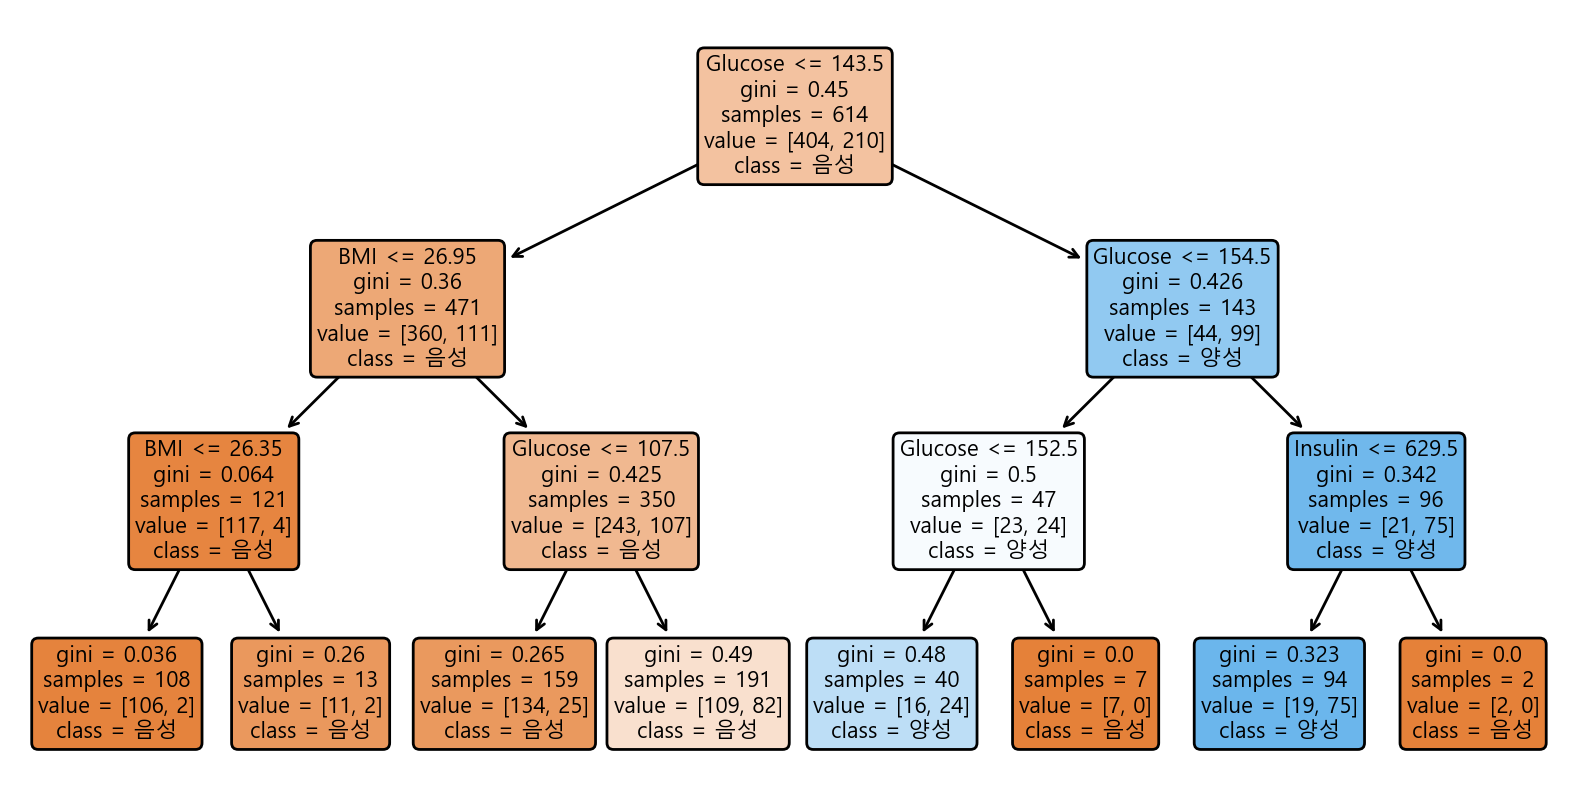

In [7]:
plt.figure(figsize=(10, 5))

# 리턴을 안받으면 그래프가 2개 출력된다. 리턴값을 따로 사용할 것이 아니므로 언더바로 받는다.
_ = plot_tree(estimator,
        feature_names=list(x_train.columns),
        class_names=['음성', '양성'],
        rounded=True,   # 노드의 모서리를 둥글게
        filled=True)     # 노드의 색상을 다르게)

plt.show()
plt.close()

#### (3) 고급 시각화

`dtreeviz` 패키지의 설치와 참조가 필요하다.

> 한글 지원하지 않음

In [8]:
# !pip install pydot
# !pip install pydotplus

In [9]:
import graphviz
import pydot
import pydotplus
from sklearn.tree import export_graphviz

In [10]:
# target_names = np.array(['음성', '양성'])

# dt_dot_data = export_graphviz(estimator, feature_names=list[x_train.columns],
#                               class_names= target_names,
#                               filled = True, rounded = True,
#                               special_characters=True)
# dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

# from Ipython.display import Image
# Image(dt_graph.create_png())


TypeError: len() of unsized object

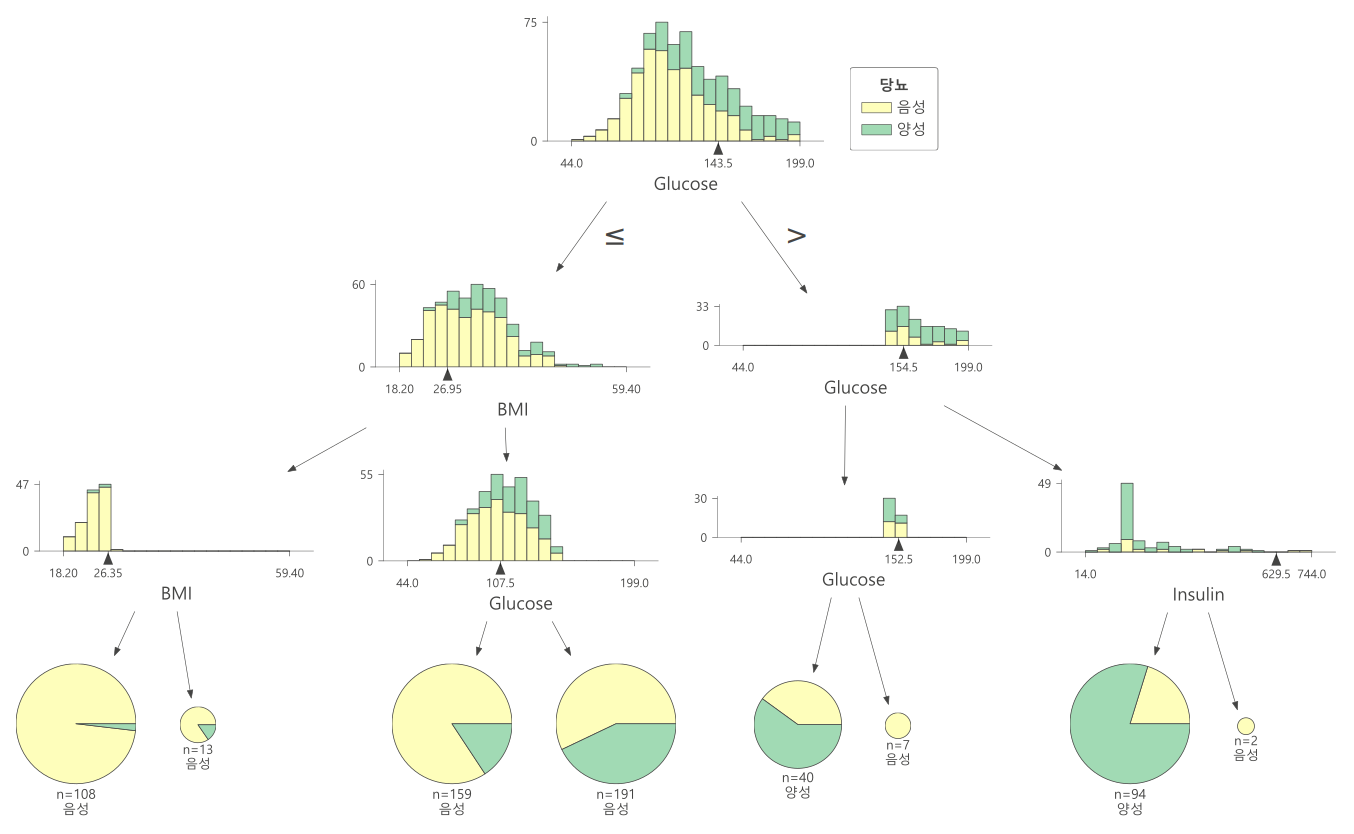

In [ ]:
viz = dtreeviz.model(estimator, 
                X_train=x_train,
                y_train=y_train,
                target_name="당뇨",
                feature_names=list(x_train.columns),
                class_names=['음성', '양성'])

viz.view(scale=2.0, fontname='Malgun Gothic')

In [ ]:
feature